In [1]:
# Import packages
import re
import os
import gc
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import math
import random
import datetime
import time
import warnings
from pdb import set_trace
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import models, transforms

In [2]:
# Create a timestamp for the summary file name
Time_Stamp = datetime.datetime.now().strftime("%Y_%m%d%_H%M")

# Create run name
Run_Name = '0411; protein; FC only' # change run_name before running

# Paths
raw_folder_path = '/home/ec2-user/Feb2025/raw_datasets/' # raw dataset folder with all the proteome and mRNA data
label_path = '/home/ec2-user/Feb2025/labels/' # label folder with all the labels
dataset_folder_path = '/home/ec2-user/Feb2025/processed_dataset2/' # dataset folder with all the processed proteome and mRNA data
model_folder_path = '/home/ec2-user/Feb2025/saved_models/' # model folder with all the models
# Define the Model
Model = 'FConly'

# Define loss function
LossFunc_Name = 'Focal' # 'CrossEntropy', 'Focal' are the options

# Define the optimizer
Optim_Name = 'AdamW' # 'Adam', 'AdamW', 'SGD', 'SGD_weight' are the options

# Dataset
Set = 'Protein + mRNA Stack' # Define the dataset to use, 'Protein', 'mRNA', 'Protein + mRNA', or 'Protein + mRNA Stack' are the options

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.15

# Standard deviation for add-noise transformation
StandardDeviation = 0.05

# Learning rate scheduler
LrScheduler = True
Learner_rate = 1e-4

# Optimizer
Weight_Decay = 0.0001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

# Loss Function (CrossEntropyLoss)
Label_Smoothing = 0.1
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

# Early stopping
Earlystopping = False

# Transformation
TransformOrNot = True

# Class weight to loss function
ApplyClassWeightToLoss = True
#  makes the loss weights equal to the fraction of each category label
#  note, a layer is added to the model so the outputs of the model are equal to the number of categories

# Batch size
batch = 16

# Epoch amount
epochs = 100

In [3]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
PFP = 'K_PD_synthetic_kde_qttumor.csv' # synthetic data
PD = pd.read_csv(dataset_folder_path+PFP)

# Data set wrangling
PD.index = PD.loc[:,'Index']
PD = PD.loc[:,PD.columns!='Index']
PD.dropna(inplace=True)

# Open the mRNA data and only keep genes (rows) that are fully quantified
MFP = 'K_MD_synthetic_kde_qttumor.csv'
MD = pd.read_csv(dataset_folder_path + MFP)

# Data set wrangling
MD.index = MD.loc[:,'Index']
MD = MD.loc[:,MD.columns!='Index']
MD = MD.drop_duplicates()
MD.dropna(inplace=True)

In [4]:
# Open the labels data
#LFP = 'SubCellBarcode.MCF7.txt'
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')
# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Extract the common indices between the proteomics and mRNA data
common_indices = list(set(PD.index).intersection(set(MD.index)))
LD = LD.loc[LD.index.isin(common_indices)]

print('Number of total labels in Krug dataset')
print(len(LD.index))
print(LD.value_counts())

Number of total labels in Krug dataset
2693
Localization
Cytosol         1036
Secretory        769
Nucleus          624
Mitochondria     264
Name: count, dtype: int64


In [5]:
PD['type'] = 'protein'
MD['type'] = 'mrna'

combined = pd.concat([PD, MD], axis=0)
combined

,CPT000814,CPT001846,X01BR001,X01BR008,X01BR009,X01BR010,X01BR015,X01BR017,X01BR018,X01BR020,...,32,33,34,35,36,37,38,39,40,type
Index,,,,,,,,,,,,,,,,,,,,,
A2ML1,0.997206,0.000621,0.003104,0.967562,0.991153,0.000466,0.002018,0.926897,0.961353,0.001707,...,0.000931,0.000000,0.004811,0.005432,0.997361,0.019556,0.003259,0.999845,0.998603,protein
AAAS,0.942729,0.812820,0.644420,0.681204,0.279994,0.617725,0.890579,0.753531,0.575819,0.547261,...,0.608412,0.741735,0.708366,0.295359,0.635729,0.613534,0.352941,0.053391,0.450567,protein
AACS,0.325625,0.174142,0.316933,0.026540,0.096694,0.990067,0.769362,0.727146,0.021419,0.154121,...,0.356977,0.145740,0.614000,0.969890,0.356666,0.163123,0.976409,0.843086,0.060531,protein
AAGAB,0.284340,0.464535,0.069222,0.182368,0.334161,0.071706,0.161415,0.641937,0.374981,0.542139,...,0.662580,0.133168,0.086450,0.827875,0.231724,0.869781,0.509390,0.923483,0.149930,protein
AAK1,0.477573,0.748720,0.618656,0.406022,0.315847,0.503337,0.367686,0.810647,0.194319,0.355890,...,0.159553,0.644886,0.537483,0.270526,0.765327,0.548192,0.399659,0.438150,0.359926,protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.812820,0.157070,0.426820,0.548657,0.858761,0.365513,0.769673,0.850535,0.635418,0.351234,...,0.760981,0.476020,0.606860,0.348595,0.385845,0.434580,0.609809,0.202701,0.506131,mrna
ZYG11B,0.165761,0.594133,0.597393,0.096228,0.222722,0.251436,0.898339,0.473227,0.698122,0.365358,...,0.417818,0.089710,0.447773,0.363340,0.331988,0.721403,0.204253,0.279839,0.251125,mrna
ZYX,0.740804,0.980599,0.422629,0.646128,0.456154,0.981220,0.333695,0.307155,0.138290,0.242278,...,0.018314,0.372963,0.673134,0.362874,0.321124,0.068602,0.376377,0.033059,0.768896,mrna


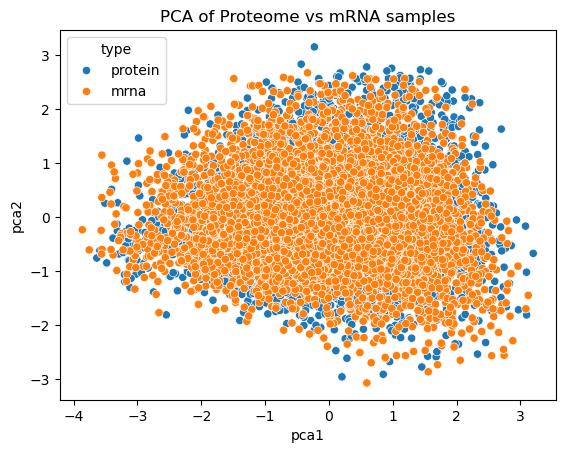

[0.09025997 0.05123463]


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

features = combined.drop(columns=['type']).values
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

combined['pca1'] = pca_result[:, 0]
combined['pca2'] = pca_result[:, 1]

sns.scatterplot(data=combined, x='pca1', y='pca2', hue='type')
plt.title("PCA of Proteome vs mRNA samples")
plt.show()
print(pca.explained_variance_ratio_)

In [7]:
# drop type column in PD and MD
PD = PD.drop(columns=['type'])
MD = MD.drop(columns=['type'])

# add column called localization based on the labels in LD, match the index of PD and MD to the index of LD
PD['localization'] = LD.loc[LD.index.isin(PD.index), 'Localization']
MD['localization'] = LD.loc[LD.index.isin(MD.index), 'Localization']

In [8]:
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def plot_omic_clusters(data_df, labels, title, use_umap=False):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from sklearn.decomposition import PCA
    from umap import UMAP

    features = data_df.values

    reducer = UMAP(n_neighbors=100, min_dist=0.05, metric='correlation', random_state=42) if use_umap else PCA(n_components=2)
    reduced = reducer.fit_transform(features)

    df_plot = pd.DataFrame({
        'x': reduced[:, 0],
        'y': reduced[:, 1],
        'label': labels
    })

    # Define fixed color palette
    fixed_palette = {
        'Cytosol': cm.Blues(0.4),        # Medium blue
        'Mitochondria': cm.Oranges(0.7), # Medium orange
        'Nucleus': cm.Greens(0.6),       # Slightly lighter green
        'Secretory': cm.Purples(0.6)    # Mid purple
    }

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_plot,
        x='x',
        y='y',
        hue='label',
        palette=fixed_palette,
        s=15,
        edgecolor='k'
    )
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()


/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


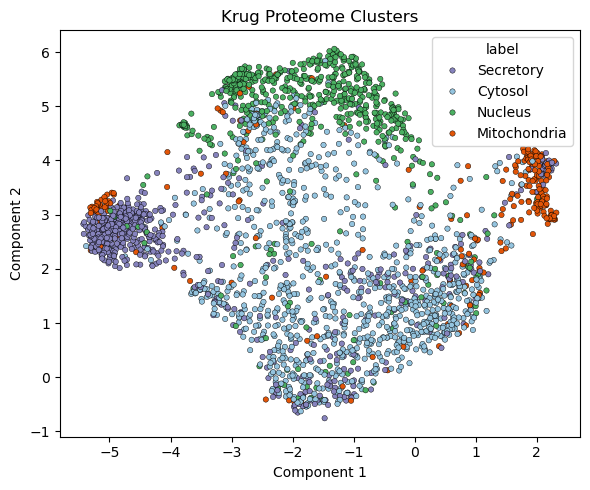

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


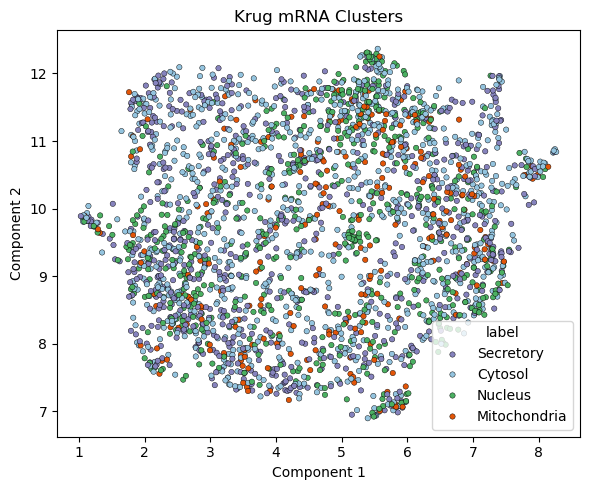

In [10]:
plot_omic_clusters(PD.drop(columns=['localization']), PD['localization'], 'Krug Proteome Clusters', use_umap=True)
plot_omic_clusters(MD.drop(columns=['localization']), MD['localization'], 'Krug mRNA Clusters', use_umap=True)

In [11]:
# Read in the synthetic data
# Mertins 
#   proteome
M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_PD_synthetic_kde_qttumor.csv'))
M_PD_synthetic.index = M_PD_synthetic.loc[:,'Index']
M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Index']

#   transcriptome
M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_MD_synthetic_kde_qttumor.csv'))
M_MD_synthetic.index = M_MD_synthetic.loc[:,'gene_name']
M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='gene_name']


# LCSCC tumor
#   proteome
lung_tumor_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_PD_synthetic_kde_qttumor.csv'))
lung_tumor_PD_synthetic.index = lung_tumor_PD_synthetic.loc[:,'Gene']
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[:, lung_tumor_PD_synthetic.columns!='Gene']

#   transcriptome
lung_tumor_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_MD_synthetic_kde_qttumor.csv'))
lung_tumor_MD_synthetic.index = lung_tumor_MD_synthetic.loc[:,'gene_name']
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[:, lung_tumor_MD_synthetic.columns!='gene_name']

# LCSCC NAT
#   proteome
lung_nat_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_PD_synthetic_kde_qttumor.csv'))
lung_nat_PD_synthetic.index = lung_nat_PD_synthetic.loc[:,'Gene']
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[:, lung_nat_PD_synthetic.columns!='Gene']

#   transcriptome
lung_nat_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_MD_synthetic_kde_qttumor.csv'))
lung_nat_MD_synthetic.index = lung_nat_MD_synthetic.loc[:,'gene_name']
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[:, lung_nat_MD_synthetic.columns!='gene_name']

# Brain glioma
#   proteome
glioma_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_PD_synthetic_kde_qttumor.csv'))
glioma_PD_synthetic.index = glioma_PD_synthetic.loc[:,'gene_name']
glioma_PD_synthetic = glioma_PD_synthetic.loc[:, glioma_PD_synthetic.columns!='gene_name']

#   transcriptome
glioma_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_MD_synthetic_kde_qttumor.csv'))
glioma_MD_synthetic.index = glioma_MD_synthetic.loc[:,'gene_name']
glioma_MD_synthetic = glioma_MD_synthetic.loc[:, glioma_MD_synthetic.columns!='gene_name']

In [12]:
# Breast
# Read in the label
LD_mcf7 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_mcf7.index = LD_mcf7.loc[:,'Protein']
LD_mcf7 = LD_mcf7.loc[:,LD_mcf7.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_mcf7.loc[:,'Localization'] != 'Unclassified'
LD_mcf7 = LD_mcf7.loc[NotUnclassInd,:]

# Lung
LD_h322 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_h322.index = LD_h322.loc[:,'Protein']
LD_h322 = LD_h322.loc[:,LD_h322.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_h322.loc[:,'Localization'] != 'Unclassified'
LD_h322 = LD_h322.loc[NotUnclassInd,:]

# Lung
LD_u251 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_u251.index = LD_u251.loc[:,'Protein']
LD_u251 = LD_u251.loc[:,LD_u251.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_u251.loc[:,'Localization'] != 'Unclassified'
LD_u251 = LD_u251.loc[NotUnclassInd,:]

In [13]:
M_common_indices = list(set(M_PD_synthetic.index).intersection(set(M_MD_synthetic.index)))
M_LD = LD_mcf7.loc[LD_mcf7.index.isin(M_common_indices)]

lung_tumor_common_indices = list(set(lung_tumor_PD_synthetic.index).intersection(set(lung_tumor_MD_synthetic.index)))
lung_tumor_LD = LD_h322.loc[LD_h322.index.isin(lung_tumor_common_indices)]

lung_nat_common_indices = list(set(lung_nat_PD_synthetic.index).intersection(set(lung_nat_MD_synthetic.index)))
lung_nat_LD = LD_h322.loc[LD_h322.index.isin(lung_nat_common_indices)]

glioma_common_indices = list(set(glioma_PD_synthetic.index).intersection(set(glioma_MD_synthetic.index)))
glioma_LD = LD_u251.loc[LD_u251.index.isin(glioma_common_indices)]


In [14]:
# add column called localization based on the labels in LD, match the index of PD and MD to the index of LD
M_PD_synthetic['localization'] = M_LD.loc[M_LD.index.isin(M_PD_synthetic.index), 'Localization']
M_MD_synthetic['localization'] = M_LD.loc[M_LD.index.isin(M_MD_synthetic.index), 'Localization']

lung_tumor_PD_synthetic['localization'] = lung_tumor_LD.loc[lung_tumor_LD.index.isin(lung_tumor_PD_synthetic.index), 'Localization']
lung_tumor_MD_synthetic['localization'] = lung_tumor_LD.loc[lung_tumor_LD.index.isin(lung_tumor_MD_synthetic.index), 'Localization']

lung_nat_PD_synthetic['localization'] = lung_nat_LD.loc[lung_nat_LD.index.isin(lung_nat_PD_synthetic.index), 'Localization']
lung_nat_MD_synthetic['localization'] = lung_nat_LD.loc[lung_nat_LD.index.isin(lung_nat_MD_synthetic.index), 'Localization']

glioma_PD_synthetic['localization'] = glioma_LD.loc[glioma_LD.index.isin(glioma_PD_synthetic.index), 'Localization']
glioma_MD_synthetic['localization'] = glioma_LD.loc[glioma_LD.index.isin(glioma_MD_synthetic.index), 'Localization']



/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


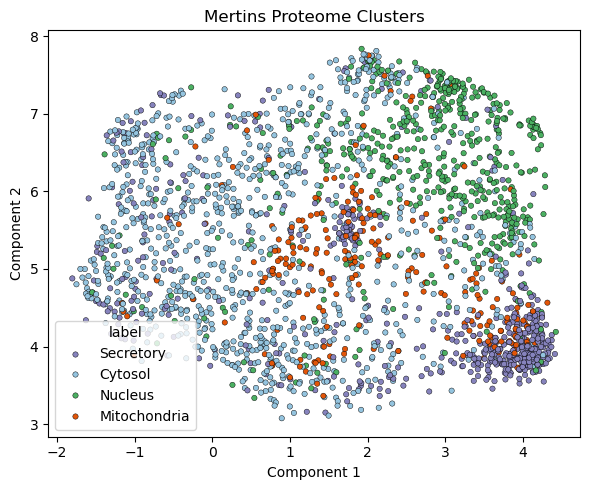

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


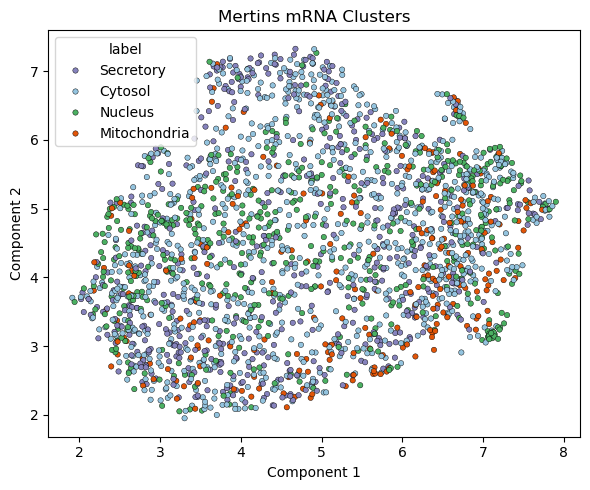

In [15]:
plot_omic_clusters(M_PD_synthetic.drop(columns=['localization']), M_PD_synthetic['localization'], 'Mertins Proteome Clusters', use_umap=True)
plot_omic_clusters(M_MD_synthetic.drop(columns=['localization']), M_MD_synthetic['localization'], 'Mertins mRNA Clusters', use_umap=True)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


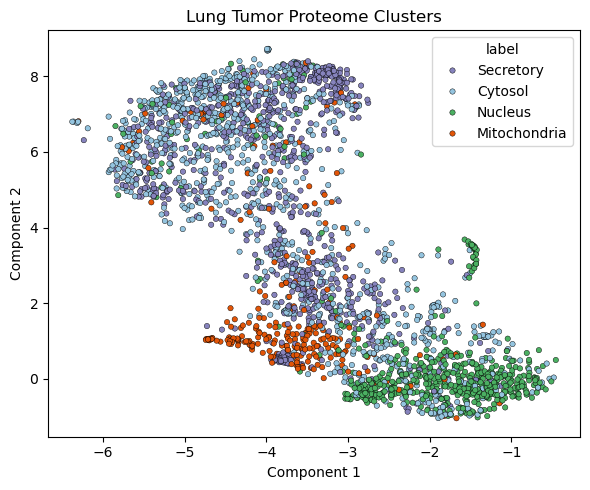

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


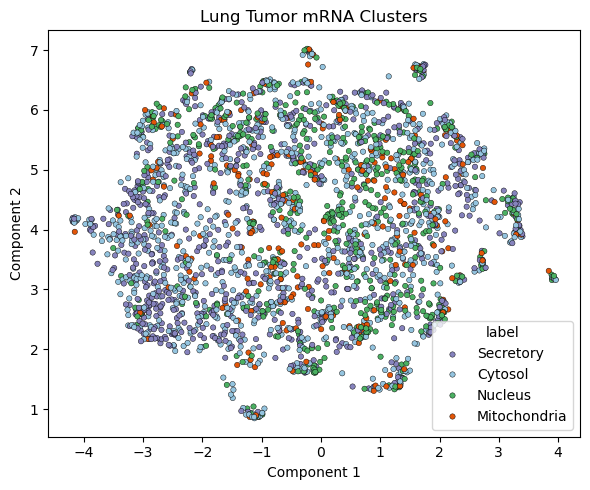

In [16]:
plot_omic_clusters(lung_tumor_PD_synthetic.drop(columns=['localization']), lung_tumor_PD_synthetic['localization'], 'Lung Tumor Proteome Clusters', use_umap=True)
plot_omic_clusters(lung_tumor_MD_synthetic.drop(columns=['localization']), lung_tumor_MD_synthetic['localization'], 'Lung Tumor mRNA Clusters', use_umap=True)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


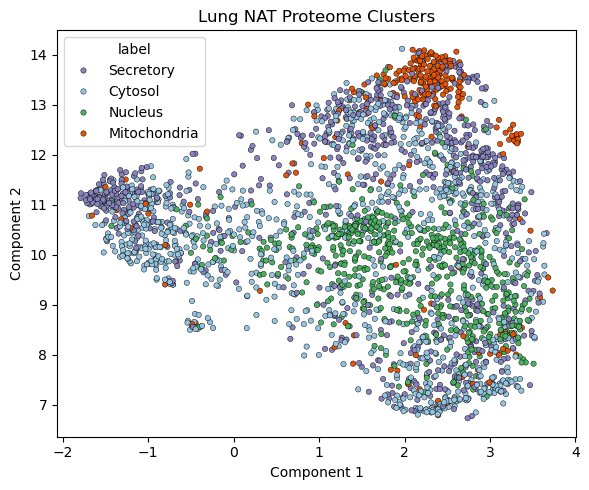

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


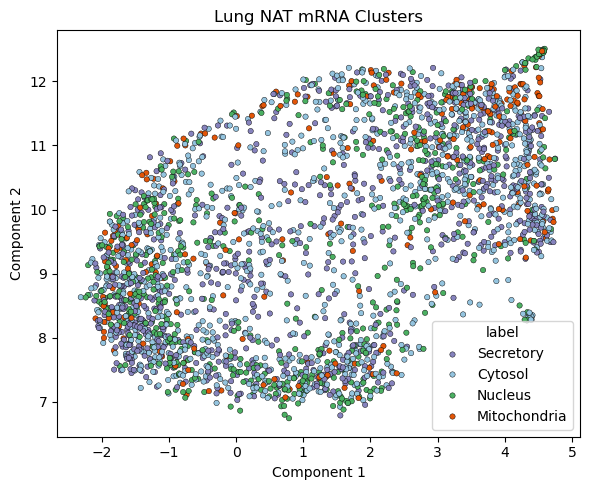

In [17]:
plot_omic_clusters(lung_nat_PD_synthetic.drop(columns=['localization']), lung_nat_PD_synthetic['localization'], 'Lung NAT Proteome Clusters', use_umap=True)
plot_omic_clusters(lung_nat_MD_synthetic.drop(columns=['localization']), lung_nat_MD_synthetic['localization'], 'Lung NAT mRNA Clusters', use_umap=True)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


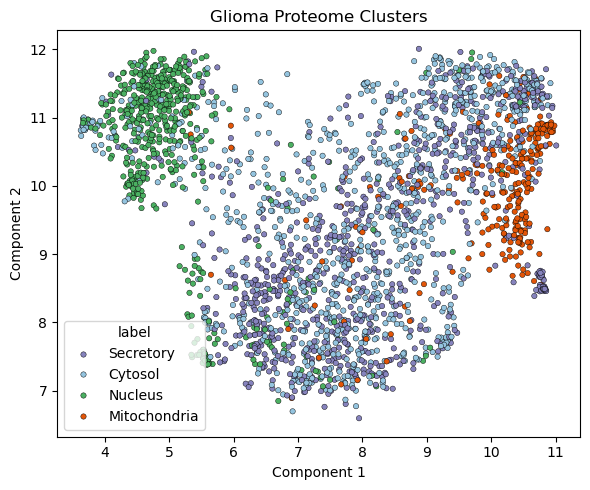

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


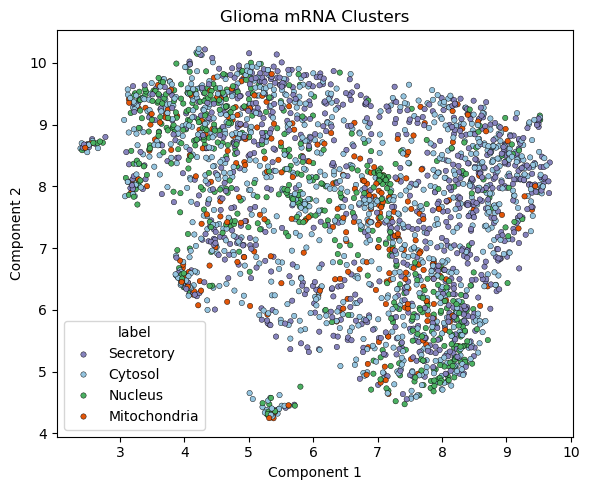

In [18]:
plot_omic_clusters(glioma_PD_synthetic.drop(columns=['localization']), glioma_PD_synthetic['localization'], 'Glioma Proteome Clusters', use_umap=True)
plot_omic_clusters(glioma_MD_synthetic.drop(columns=['localization']), glioma_MD_synthetic['localization'], 'Glioma mRNA Clusters', use_umap=True)